In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
plt.style.use('jpg')

from astropy.table import Table, vstack
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(70, 0.3)

import hhana
from proj_utils import *

In [2]:
bell = Table.read('data/bell-table.txt', format='ascii').to_pandas()
bell.set_index('Color', inplace=True)
def mass_to_light(band, color_name, color_val):
    log_ml = bell.loc[color_name, 'a'+band] + bell.loc[color_name, 'b'+band]*color_val
    return 10.0**log_ml
Mi_sun = 4.48
L_i = lambda Mi: 10**((Mi_sun - Mi)/2.5)

In [3]:
sample = get_sample()
nsa = get_nsa()
yang = get_yang(logMh_min=12.5)

yang_idx_sky, _, _ = sample.skycoord.match_to_catalog_sky(yang.skycoord)
yang_idx_Mpc, _ = find_nearest_in_Mpc(sample, yang, cosmo)
nsa_idx_sky, _, _ = sample.skycoord.match_to_catalog_sky(nsa.skycoord)
nsa_idx_Mpc, _ = find_nearest_in_Mpc(sample, nsa, cosmo)

clust_2p1_fits = {b:Table.read('data/clust_2.1_fits_'+b+'-band.csv') for b in 'gi'}
clust_3p1_fits = {b:Table.read('data/clust_3.1_fits_'+b+'-band.csv') for b in 'gi'}
sample.add_col('r_1/2(g)', sample['FLUX_RADIUS(g)']*0.168)

In [4]:
cmap = plt.cm.rainbow
def plot_size_vs_mag(sam, z):
    D_A = cosmo.angular_diameter_distance(z).to('kpc').value
    D_L = cosmo.luminosity_distance(z).to('pc').value
    r_eff = sam['r_e']*D_A*u.arcsec.to('radian')
    abs_mag = sam['m_tot'] - 5*np.log10(D_L) + 5
    fig, ax = hhana.plot.size_vs_mag()
    ax.scatter(abs_mag, np.log10(r_eff), c=cmap(0.0), alpha=0.9,
               s=120, label='HSC UDGs (this work)', edgecolor='k')
    ax.legend(loc=0, fontsize=18);
    return fig, ax, abs_mag, r_eff

hugs-id    dr_e     mass (x10^7)
------- ---------- -------------
    198  0.4215288 3.00001793753
    199 -0.5479152 5.62168982457
    201  0.2275896   2.630122186
    205 -0.0055272 5.92007483296
    336  -0.419412 5.62765846525
    337  -2.480772 1.92054795319


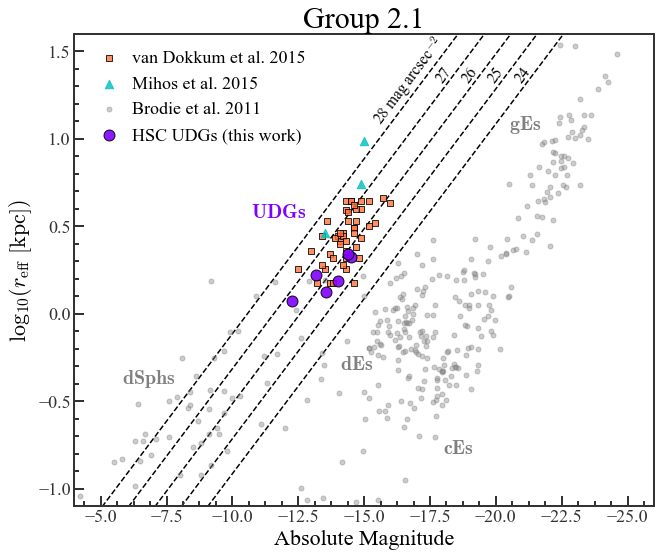

In [5]:
band = 'g'
clust = clusters['2.1']
sam_idx, _ = sample.query_radius(clust['coord'], clust['size'])
z = np.unique(yang[yang_idx_Mpc][sam_idx])['z']
params_2p1 = clust_2p1_fits[band]
fig, ax, abs_mag, r_eff = plot_size_vs_mag(params_2p1, z)
params_2p1['abs_mag'] = abs_mag
params_2p1['z'] = z
params_2p1['r_kpc'] = r_eff
params_2p1['clust-id'] = 2.1
ax.set_title('Group 2.1', fontsize=30)
merged = params_2p1.to_pandas().merge(sample[sam_idx].to_pandas(), on='hugs-id')
ml = mass_to_light('i', 'g-i', sample[sam_idx]['g-i'])
mass = L_i(abs_mag)*ml
print(Table([merged['hugs-id'], merged['r_e']-merged['r_e(g)'], mass/1e7], 
            names=['hugs-id', 'dr_e', 'mass (x10^7)']))

In [6]:
z

array([ 0.01723567])

[ 0.02064937]
hugs-id   dr_e_1     dr_e_2    mass (x10^7)
------- ---------- ---------- -------------
    348 -0.8182608 -0.1467816 2.76973794526
    346 -0.3485664  0.2452296 2.68485529144
    341  0.1101744   1.722924 3.77262904035
    215 -0.4885776  0.2066064  12.069430497
    216  0.3504144  1.5257088 8.80385098988
    345  0.1066128  0.0747768 2.02781063991
    218  0.0899472  0.3051888 9.14543962414
    220  -0.941808  0.1938888  2.1891253572
    221  0.4023768  2.6493096 10.2566404826


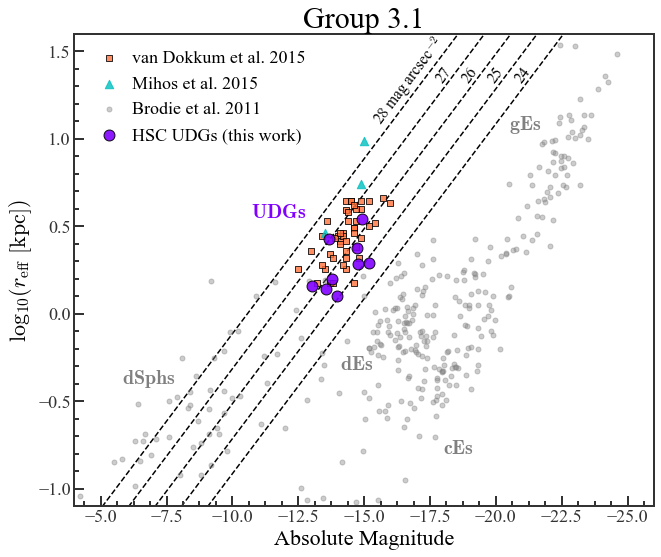

In [7]:
band = 'g'
clust = clusters['3.1']
sam_idx, _ = sample.query_radius(clust['coord'], clust['size'])
z = np.unique(yang[yang_idx_Mpc][sam_idx])['z']
params_3p1 = clust_3p1_fits[band]
fig, ax, abs_mag, r_eff = plot_size_vs_mag(params_3p1, z)
params_3p1['abs_mag'] = abs_mag
params_3p1['z'] = z
print(z)
params_3p1['r_kpc'] = r_eff
params_3p1['clust-id'] = 3.1
ax.set_title('Group 3.1', fontsize=30)
merged = params_3p1.to_pandas().merge(sample[sam_idx].to_pandas(), on='hugs-id')
ml = mass_to_light('i', 'g-i', sample[sam_idx]['g-i'])
mass = L_i(abs_mag)*ml
print(Table([merged['hugs-id'], merged['r_e']-merged['r_e(g)'], merged['r_e']-merged['r_1/2(g)'], mass/1e7], 
             names=['hugs-id', 'dr_e_1', 'dr_e_2', 'mass (x10^7)']))

In [10]:
clust_num = ['2.1', '3.1']
candy_idx = np.array([])
for num in clust_num:
    clust = clusters[num]b
    sam_idx, _ = sample.query_radius(clust['coord'], clust['size'])
    candy_idx = np.concatenate([sam_idx, candy_idx]).astype(int)

vD = Table.read('../../projects/hsc-hugs-paper-I/data/size_vs_mag/vanDokkum2015_Table_1.txt', format='ascii')

candy = vstack([params_2p1[params_2p1['r_kpc']>1.5], params_3p1[params_3p1['r_kpc']>1.5]])
mag_vs_kpc = lambda sb, r: sb-2.5*np.log10(2*np.pi*(u.radian.to('arcsec')*1e3*r/10.0)**2)

In [19]:
import pandas as pd
z = 0.01723567
eye_candy = {'g': pd.read_csv('data/eye_2.1_fits_g-band.csv'),
             'i': pd.read_csv('data/eye_2.1_fits_i-band.csv')}

D_A = cosmo.angular_diameter_distance(z).to('kpc').value
D_L = cosmo.luminosity_distance(z).to('pc').value
r_eff = eye_candy['g']['r_e']*D_A*u.arcsec.to('radian')
eye_candy['dir'] = '/Users/protostar/local_data/hsc/eye-candy-HST-C25/'
eye_candy['g']['abs_mag'] =  eye_candy['g']['m_tot'] - 5*np.log10(D_L) + 5
eye_candy['g']['r_kpc'] = r_eff

In [22]:
eye_candy['g']['abs_mag']

0   -14.20164
Name: abs_mag, dtype: float64

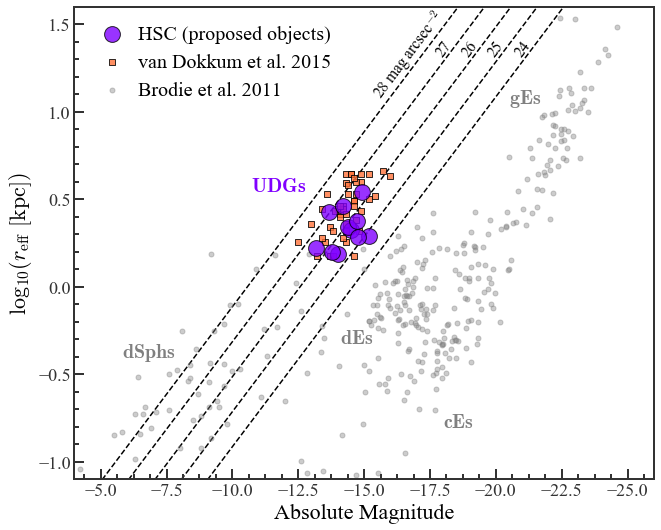

In [21]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(candy['abs_mag'], np.log10(candy['r_kpc']), marker='o',
           s=250, c=cmap(0.0), alpha=0.8, edgecolors='k', label='HSC (proposed objects)',
           zorder=10)
ax.scatter(eye_candy['g']['abs_mag'], np.log10(eye_candy['g']['r_kpc']), marker='o',
           s=250, c=cmap(0.0), alpha=0.8, edgecolors='k', label=None,
           zorder=10)





#ax.plot(vD[vD['id']=='DF17']['Mg'], np.log10(vD[vD['id']=='DF17']['reff']), 's')

hhana.plot.size_vs_mag(subplots=(fig, ax), show_Mihos=False)
ax.legend(fontsize=20)

rmin, rmax = 1.35, 4.5
mumin, mumax = 24.5, 27.8
verts = [[mag_vs_kpc(mumax, rmin), np.log10(rmin)], 
         [mag_vs_kpc(mumin, rmin), np.log10(rmin)], 
         [mag_vs_kpc(mumin, rmax), np.log10(rmax)],
         [mag_vs_kpc(mumax, rmax), np.log10(rmax)]]
verts =  np.array(verts)
poly = Polygon(verts, True, alpha=0.3, color='#f46d43', zorder=-10)
fig.savefig('figures/size-vs-mag.pdf')
#ax.add_patch(poly)